In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

import seaborn as sns

import os
import pickle

from copy import deepcopy

import time

import tqdm

In [2]:
from matplotlib import gridspec
def create_subtitle(fig: plt.Figure, grid: gridspec.SubplotSpec, title: str, fontsize: int=16):
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold', fontsize=fontsize)
    #row.set_title(f'{title}\n')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

In [3]:
#outdir = '../../output/experiment'
outdir = './output/synthetic/multivariate/'
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Sample sequences

In [4]:
def generate_data(N, pi, mu, sigma):
    D = mu.shape[1]
    
    z_list = np.random.choice(np.arange(len(pi)), N, replace=True)
    
    X = np.zeros((N, D))
    for i, z in enumerate(z_list):
        X_i = np.random.multivariate_normal(mu[z], sigma[z])
        X[i, :] = X_i
    
    return X

In [5]:
def add_subplot_axes(ax, rect, axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    #subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    subax = fig.add_axes([x, y, width, height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
        
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)

    return subax

In [6]:
N = 10000
alpha_ol = 0.01

pi = np.array([0.5, 0.5]),
mu1 = np.array([[3.0, 2.0, 1.0], [-2.0, 3.0, 2.0]])
mu2 = np.array([[6.0, 4.0, 2.0], [-4.0, 6.0, 4.0]])
sigma = np.array([[[1.0, -0.8, 0.2], [-0.8, 1.0, 0.3], [0.2, 0.3, 1.0]], 
                  [[1.0, -0.8, 0.2], [-0.8, 1.0, 0.3], [0.2, 0.3, 1.0]]])

u = 20

In [7]:
np.random.seed(0)
X_abrupt = np.zeros((2*N, 3))
Xj_former = generate_data(N, pi, mu1, sigma)
X_abrupt[:N, :] = Xj_former
Xj_latter = generate_data(N, pi, mu2, sigma)
X_abrupt[N:, :] = Xj_latter

#idxes_ol = np.random.choice(np.arange(N), int(alpha_ol*N))
idxes_ol_abrupt = np.random.choice(np.arange(2*N), int(alpha_ol*2*N))
X_abrupt[idxes_ol_abrupt, :] = np.random.uniform(-u, u, len(idxes_ol_abrupt)*3).reshape(-1, 3)    

In [8]:
np.random.seed(1)
X_gradual = np.zeros((2*N, 3))
Xj_former = generate_data(N, pi, mu1, sigma)
X_gradual[:N, :] = Xj_former
#Xj_trans = np.linspace(mu1, mu2, 300).ravel() + np.random.normal(0, sigma, 300)
Xj_trans = np.vstack([ generate_data(1, pi, mu1 + (t-N+1)/300 * (mu2-mu1), sigma) for t in range(N, N+300) ])
X_gradual[N:(N+300), :] = Xj_trans
Xj_latter = generate_data(N-300, pi, mu2, sigma)
X_gradual[N+300:, :] = Xj_latter

#idxes_ol = np.random.choice(np.arange(N), int(alpha_ol*N))
idxes_ol_gradual = np.random.choice(np.arange(2*N), int(alpha_ol*2*N))
X_gradual[idxes_ol_gradual, :] = np.random.uniform(-u, u, len(idxes_ol_gradual)).reshape(-1, 1)

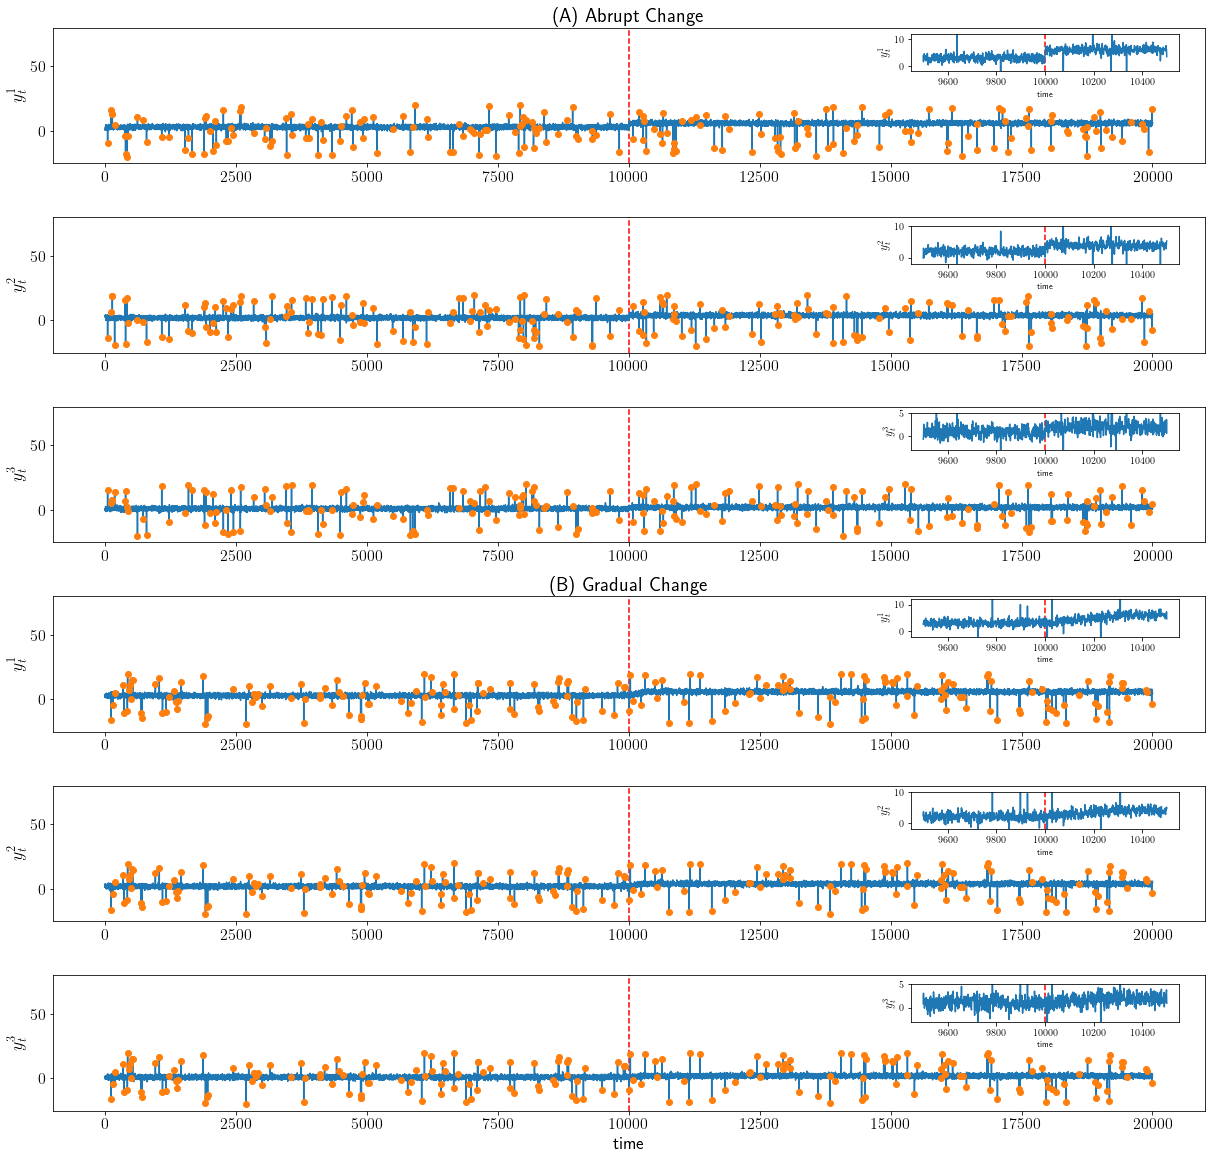

In [41]:
times = np.arange(1, 2*N+1)
rect0 = [0.8, 1.3, 0.3, 0.3]
rect1 = [0.8, 0.95, 0.3, 0.3]
rect2 = [0.8, 0.65, 0.3, 0.3]

rect3 = [0.8, 0.35, 0.3, 0.3]
rect4 = [0.8, 0.0, 0.3, 0.3]
rect5 = [0.8, -0.35, 0.3, 0.3]

fig, axes = plt.subplots(6, 1, sharex=True, figsize=(16, 16))

axes[0].plot(times, X_abrupt[:, 0])
axes[0].plot(times[idxes_ol_abrupt], X_abrupt[idxes_ol_abrupt, 0], marker='o', linestyle='None')
axes[0].axvline(10000, linestyle='dashed', color='red', zorder=1)
axes[0].xaxis.set_tick_params(which='both', labelbottom=True)
axes[0].set_ylim(-25, 80)
#axes[0].set_xlabel('time', fontsize=18)
axes[0].set_ylabel(r'$y_{t}^{1}$', fontsize=18)
axes[0].tick_params(labelsize=16)
axes[0].set_title('(A) Abrupt Change', fontsize=20)

subax0 = add_subplot_axes(axes[0], rect0)
subax0.plot(np.arange(9500, 10501), X_abrupt[9499:10500, 0])
subax0.axvline(10000, linestyle='dashed', color='red', zorder=1)
subax0.set_ylim(-2, 12)
subax0.set_xlabel('time', fontsize=8)
subax0.set_ylabel(r'$y_{t}^{1}$', fontsize=12)
subax0.tick_params(labelsize=10)

axes[1].plot(times, X_abrupt[:, 1])
axes[1].plot(times[idxes_ol_abrupt], X_abrupt[idxes_ol_abrupt, 1], marker='o', linestyle='None')
axes[1].axvline(10000, linestyle='dashed', color='red', zorder=1)
axes[1].xaxis.set_tick_params(which='both', labelbottom=True)
axes[1].set_ylim(-25, 80)
#axes[1].set_xlabel('time', fontsize=18)
axes[1].set_ylabel(r'$y_{t}^{2}$', fontsize=18)
axes[1].tick_params(labelsize=16)

subax1 = add_subplot_axes(axes[1], rect1)
subax1.plot(np.arange(9500, 10501), X_abrupt[9499:10500, 1])
subax1.axvline(10000, linestyle='dashed', color='red', zorder=1)
subax1.set_ylim(-2, 10)
subax1.set_xlabel('time', fontsize=8)
subax1.set_ylabel(r'$y_{t}^{2}$', fontsize=12)
subax1.tick_params(labelsize=10)

axes[2].plot(times, X_abrupt[:, 2])
axes[2].plot(times[idxes_ol_abrupt], X_abrupt[idxes_ol_abrupt, 2], marker='o', linestyle='None')
axes[2].axvline(10000, linestyle='dashed', color='red', zorder=1)
axes[2].xaxis.set_tick_params(which='both', labelbottom=True)
axes[2].set_ylim(-25, 80)
#axes[2].set_xlabel('time', fontsize=18)
axes[2].set_ylabel(r'$y_{t}^{3}$', fontsize=18)
axes[2].tick_params(labelsize=16)

subax2 = add_subplot_axes(axes[2], rect2)
subax2.plot(np.arange(9500, 10501), X_abrupt[9499:10500, 2])
subax2.axvline(10000, linestyle='dashed', color='red', zorder=1)
subax2.set_ylim(-3, 5)
subax2.set_xlabel('time', fontsize=8)
subax2.set_ylabel(r'$y_{t}^{3}$', fontsize=12)
subax2.tick_params(labelsize=10)

axes[3].plot(times, X_gradual[:, 0])
axes[3].plot(times[idxes_ol_gradual], X_gradual[idxes_ol_gradual, 0], marker='o', linestyle='None')
axes[3].axvline(10000, linestyle='dashed', color='red', zorder=1)
axes[3].xaxis.set_tick_params(which='both', labelbottom=True)
axes[3].set_ylim(-25, 80)
#axes[3].set_xlabel('time', fontsize=18)
axes[3].set_ylabel(r'$y_{t}^{1}$', fontsize=18)
axes[3].tick_params(labelsize=16)
axes[3].set_title('(B) Gradual Change', fontsize=20)

subax3 = add_subplot_axes(axes[3], rect3)
subax3.plot(np.arange(9500, 10501), X_gradual[9499:10500, 0])
subax3.axvline(10000, linestyle='dashed', color='red', zorder=1)
subax3.set_ylim(-2, 12)
subax3.set_xlabel('time', fontsize=8)
subax3.set_ylabel(r'$y_{t}^{1}$', fontsize=12)
subax3.tick_params(labelsize=10)

axes[4].plot(times, X_gradual[:, 1])
axes[4].plot(times[idxes_ol_gradual], X_gradual[idxes_ol_gradual, 1], marker='o', linestyle='None')
axes[4].axvline(10000, linestyle='dashed', color='red', zorder=1)
axes[4].xaxis.set_tick_params(which='both', labelbottom=True)
axes[4].set_ylim(-25, 80)
#axes[4].set_xlabel('time', fontsize=18)
axes[4].set_ylabel(r'$y_{t}^{2}$', fontsize=18)
axes[4].tick_params(labelsize=16)

subax4 = add_subplot_axes(axes[4], rect4)
subax4.plot(np.arange(9500, 10501), X_gradual[9499:10500, 1])
subax4.axvline(10000, linestyle='dashed', color='red', zorder=1)
subax4.set_ylim(-2, 10)
subax4.set_xlabel('time', fontsize=8)
subax4.set_ylabel(r'$y_{t}^{2}$', fontsize=12)
subax4.tick_params(labelsize=10)

axes[5].plot(times, X_gradual[:, 2])
axes[5].plot(times[idxes_ol_gradual], X_gradual[idxes_ol_gradual, 2], marker='o', linestyle='None')
axes[5].axvline(10000, linestyle='dashed', color='red', zorder=1)
axes[5].xaxis.set_tick_params(which='both', labelbottom=True)
axes[5].set_ylim(-25, 80)
axes[5].set_xlabel('time', fontsize=18)
axes[5].set_ylabel(r'$y_{t}^{3}$', fontsize=18)
axes[5].tick_params(labelsize=16)

subax5 = add_subplot_axes(axes[5], rect5)
subax5.plot(np.arange(9500, 10501), X_gradual[9499:10500, 2])
subax5.axvline(10000, linestyle='dashed', color='red', zorder=1)
subax5.set_ylim(-3, 5)
subax5.set_xlabel('time', fontsize=8)
subax5.set_ylabel(r'$y_{t}^{3}$', fontsize=12)
subax5.tick_params(labelsize=10)

#grid = plt.GridSpec(6, 1)
#create_subtitle(fig, grid[0, ::], '(A) Abrupt Change', fontsize=24)
#create_subtitle(fig, grid[3, ::], '(B) Gradual Change', fontsize=24)

plt.subplots_adjust(top = 0.95, bottom=0.01, left=0.00, right=1.00, hspace=0.4, wspace=0.9)
#plt.tight_layout()
plt.savefig(os.path.join(outdir, 'plot_sample_sequence_multivariate_synthetic_datasets.pdf'), bbox_inches='tight', dpi=200)

# Computation time

In [12]:
with open('./output/synthetic/univariate/abrupt_single/measured_total_time_by_algorithm.pkl', 'rb') as f:
    measured_total_time_by_algorithm_abrupt_single = pickle.load(f)
    
with open('./output/synthetic/univariate/abrupt_mixture/measured_total_time_by_algorithm.pkl', 'rb') as f:
    measured_total_time_by_algorithm_abrupt_mixture = pickle.load(f)

with open('./output/synthetic/univariate/gradual_single/measured_total_time_by_algorithm.pkl', 'rb') as f:
    measured_total_time_by_algorithm_gradual_single = pickle.load(f)

with open('./output/synthetic/univariate/gradual_mixture/measured_total_time_by_algorithm.pkl', 'rb') as f:
    measured_total_time_by_algorithm_gradual_mixture = pickle.load(f)

In [17]:
with open('./output/synthetic/univariate/abrupt_single/measured_each_time_by_algorithm.pkl', 'rb') as f:
    measured_each_time_by_algorithm_abrupt_single = pickle.load(f)
    
with open('./output/synthetic/univariate/abrupt_mixture/measured_each_time_by_algorithm.pkl', 'rb') as f:
    measured_each_time_by_algorithm_abrupt_mixture = pickle.load(f)

with open('./output/synthetic/univariate/gradual_single/measured_each_time_by_algorithm.pkl', 'rb') as f:
    measured_each_time_by_algorithm_gradual_single = pickle.load(f)

with open('./output/synthetic/univariate/gradual_mixture/measured_each_time_by_algorithm.pkl', 'rb') as f:
    measured_each_time_by_algorithm_gradual_mixture = pickle.load(f)

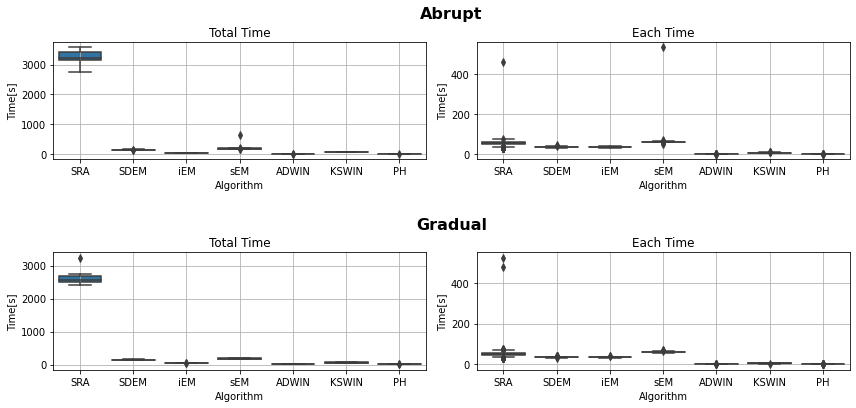

In [25]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(12, 6))

# abrupt/mixture
sns.boxplot(x='variable', y='value', data=measured_total_time_by_algorithm_abrupt_mixture, ax=axes[0, 0])
axes[0, 0].set_title('Total Time')
axes[0, 0].set_xlabel('Algorithm')
axes[0, 0].set_ylabel('Time[s]')
axes[0, 0].xaxis.set_tick_params(which='both', labelbottom=True)
axes[0, 0].grid(zorder=1)

sns.boxplot(x='Algorithm', y='Time', data=measured_each_time_by_algorithm_abrupt_mixture, ax=axes[0, 1])
axes[0, 1].set_title('Each Time')
axes[0, 1].set_ylabel('Time[s]')
axes[0, 1].xaxis.set_tick_params(which='both', labelbottom=True)
axes[0, 1].grid(zorder=1)

# gradual/mixture
sns.boxplot(x='variable', y='value', data=measured_total_time_by_algorithm_gradual_mixture, ax=axes[1, 0])
axes[1, 0].set_title('Total Time')
axes[1, 0].set_xlabel('Algorithm')
axes[1, 0].set_ylabel('Time[s]')
axes[1, 0].xaxis.set_tick_params(which='both', labelbottom=True)
axes[1, 0].grid(zorder=1)

sns.boxplot(x='Algorithm', y='Time', data=measured_each_time_by_algorithm_gradual_mixture, ax=axes[1, 1])
axes[1, 1].set_title('Each Time')
axes[1, 1].set_ylabel('Time[s]')
axes[1, 1].grid(zorder=1)

grid = plt.GridSpec(2, 2)
create_subtitle(fig, grid[0, ::], 'Abrupt')
create_subtitle(fig, grid[1, ::], 'Gradual')

plt.tight_layout()
plt.savefig(os.path.join(outdir, 'summary_measured_time_by_algorithm_synthetic_univariate.pdf'), 
            bbox_inches='tight', dpi=300)

# Dependency on Hyperparamters

In [29]:
with open('./output/synthetic/univariate/abrupt_mixture/auc_sra.pkl', 'rb') as f:
    auc_sra_df_abrupt = pickle.load(f)
    
with open('./output/synthetic/univariate/gradual_mixture/auc_sra.pkl', 'rb') as f:
    auc_sra_df_gradual = pickle.load(f)

In [30]:
auc_sra_df = pd.concat([auc_sra_df_abrupt, auc_sra_df_gradual], axis=1)

In [31]:
auc_sra_df.to_latex('./output/synthetic/univariate/auc_sra_1D_mixture.tex', float_format='%.3f')

## MSE

In [52]:
def experiment1_comparison_mse(
    # SDEM
    r_list_sdem=[0.0001, 0.001, 0.005, 0.01], 
    # SEM
    r_list_sem=[0.01, 0.05, 0.1],
    # SRA
    gamma_list_sra=[1, 3, 5, 10, 15], 
    u=10, 
    N=10000,
    alpha_ol=0.01, # ratio of outliers
    eval_start=500,
    eval_end=1000,
    burnin=1000,
    mu1=np.array([0.5]),
    mu2=np.array([1.0]),
    cps=np.array([9999]),
    start=0, 
    end=None,
    T=100,
    N_thr=1000,
    n_trial=10):

    mse_sdem_eval, mse_sdem_former, mse_sdem_latter, mse_sdem_total = [], [], [], []
    mse_iem_eval, mse_iem_former, mse_iem_latter, mse_iem_total = [], [], [], []
    mse_sem_eval, mse_sem_former, mse_sem_latter, mse_sem_total = [], [], [], []
    mse_sra_eval, mse_sra_former, mse_sra_latter, mse_sra_total = [], [], [], []
    
    for trial in tqdm.tqdm(range(n_trial)):
        # generate data
        np.random.seed(trial)
        X = np.zeros((2*N, 1))
        Xj_former = generate_data(N, pi, mu1, sigma)
        X[:N, 0] = Xj_former.ravel()
        Xj_latter = generate_data(N, pi, mu2, sigma)
        X[N:, 0] = Xj_latter.ravel()

        idxes_ol = np.random.choice(np.arange(N), int(alpha_ol*N))
        X[idxes_ol, :] = np.random.uniform(-u, u, len(idxes_ol)).reshape(-1, 1)    
        
        print('# SDEM')
        for i, r in enumerate(r_list_sdem):
            rho_const = np.repeat([r], 2*N)
            sdem = SDEM(rho_const, 1.0, n_components=1)
            #seed = i*len(r_list_sdem) + trial
            sdem.fit(X[:10, :])
            for t in range(X.shape[0]):
                sdem.update(X[t, :])
            
            means_est_sdem = np.array(sdem.means_list).reshape(2*N, 1)
            ev, former, latter, total = calc_metrics(means_est_sdem, mu1, mu2, eval_start, eval_end, burnin)
            mse_sdem_eval.append([trial, r, ev])
            mse_sdem_former.append([trial, r, former])
            mse_sdem_latter.append([trial, r, latter])
            mse_sdem_total.append([trial, r, total])
            
        print('# IEM')
        iem = SDEM(1.0/np.arange(1, 2*N+1), 1.0, n_components=1)
        iem.fit(X[:10, :])
        for t in range(X.shape[0]):
            iem.update(X[t, :])

        means_est_iem = np.array(iem.means_list).reshape(2*N, 1)
        ev, former, latter, total = calc_metrics(means_est_iem, mu1, mu2, eval_start, eval_end, burnin)
        mse_iem_eval.append([trial, ev])
        mse_iem_former.append([trial, former])
        mse_iem_latter.append([trial, latter])
        mse_iem_total.append([trial, total])
        
        print('# SEM')
        for i, r in enumerate(r_list_sem):
            seed = i*len(r_list_sem) + trial
            #np.random.seed(seed)
            
            rho_const = np.repeat([r], 2*N)
            #theta_est_sem = sem(X, theta0, rho_const)
            _, mu_est_sem, _ = sem(X, theta0, rho_const, start, end, seed)
            
            print(mu_est_sem)
            
            #ev, former, latter, total = calc_metrics(theta_est_sem[:, 3:5], mu1, mu2, eval_start, eval_end, burnin)
            ev, former, latter, total = calc_metrics(mu_est_sem, mu1, mu2, eval_start, eval_end, burnin)
            mse_sem_eval.append([trial, r, ev])
            mse_sem_former.append([trial, r, former])
            mse_sem_latter.append([trial, r, latter])
            mse_sem_total.append([trial, total])

        print('# SRA')
        for j, gamma in enumerate(gamma_list_sra):
            ratio_list = [0.01*gamma, 0.03*gamma, 0.05*gamma, 0.1*gamma]
            M_list = [gamma, 2*gamma, 4*gamma]
            for l, ratio in enumerate(ratio_list):
                for m, M in enumerate(M_list):
                    seed = j*len(gamma_list_sra) + l*len(ratio_list) + m * len(M_list) + trial
                    
                    np.random.seed(seed)
                    #theta_est_sra = sra(X, theta0, rho_const, gamma)
                    _, mu_est_sra, _ = sra(X, theta0, rho_const, gamma)
        
                    #ev, former, latter, total = calc_metrics(theta_est_sra[:, 3:5], mu1, mu2, eval_start, eval_end, burnin)
                    ev, former, latter, total = calc_metrics(mu_est_sra, mu1, mu2, eval_start, eval_end, burnin)
                    mse_sra_eval.append([trial, gamma, ratio, M, ev])
                    mse_sra_former.append([trial, gamma, ratio, M, former])
                    mse_sra_latter.append([trial, gamma, ratio, M, latter])
                    mse_sra_total.append([trial, gamma, ratio, M, total])
                    #former = np.sum((theta_est_sra[burnin:N+1, 3:5] - mu1)**2, axis=1)
                    #mse_sra_former.append([trial, gamma, ratio, M, former])
        
                    #latter = np.sum((theta_est_sra[N+1:, 3:5] - mu2)**2, axis=1)
                    #mse_sra_latter.append([trial, gamma, ratio, M, latter])
        
                    #overall = np.hstack((former, latter))
                    #mse_sra_total.append([trial, gamma, ratio, M, overall])

    mse_sdem_eval_df = pd.DataFrame(mse_sdem_eval, columns=['trial', 'r', 'mse'])
    mse_sdem_former_df = pd.DataFrame(mse_sdem_former, columns=['trial', 'r', 'mse'])
    mse_sdem_latter_df = pd.DataFrame(mse_sdem_latter, columns=['trial', 'r', 'mse'])
    mse_sdem_total_df = pd.DataFrame(mse_sdem_total, columns=['trial', 'r', 'mse'])

    mse_iem_eval_df = pd.DataFrame(mse_iem_eval, columns=['trial', 'mse'])
    mse_iem_former_df = pd.DataFrame(mse_iem_former, columns=['trial', 'mse'])
    mse_iem_latter_df = pd.DataFrame(mse_iem_latter, columns=['trial', 'mse'])
    mse_iem_total_df = pd.DataFrame(mse_iem_total, columns=['trial', 'mse'])

    mse_sem_eval_df = pd.DataFrame(mse_sem_eval, columns=['trial', 'r', 'mse'])
    mse_sem_former_df = pd.DataFrame(mse_sem_former, columns=['trial', 'r', 'mse'])
    mse_sem_latter_df = pd.DataFrame(mse_sem_latter, columns=['trial', 'r', 'mse'])
    mse_sem_total_df = pd.DataFrame(mse_sem_total, columns=['trial', 'r', 'mse'])

    mse_sra_eval_df = pd.DataFrame(mse_sra_eval, columns=['trial', 'r', 'mse'])
    mse_sra_former_df = pd.DataFrame(mse_sra_former, columns=['trial', 'r', 'mse'])
    mse_sra_latter_df = pd.DataFrame(mse_sra_latter, columns=['trial', 'r', 'mse'])
    mse_sra_total_df = pd.DataFrame(mse_sra_total, columns=['trial', 'r', 'mse'])


    return mse_sdem_eval_df, mse_sdem_former_df, mse_sdem_latter_df, mse_sdem_total_df, \
           mse_iem_eval_df, mse_iem_former_df, mse_iem_latter_df, mse_iem_total_df, \
           mse_sem_eval_df, mse_sem_former_df, mse_sem_latter_df, mse_sem_total_df, \
           mse_sra_eval_df, mse_sra_former_df, mse_sra_latter_df, mse_sra_total_df

In [62]:
mse_sdem_eval_df, mse_sdem_former_df, mse_sdem_latter_df, mse_sdem_total_df, \
mse_iem_eval_df, mse_iem_former_df, mse_iem_latter_df, mse_iem_total_df, \
mse_sem_eval_df, mse_sem_former_df, mse_sem_latter_df, mse_sem_total_df, \
mse_sra_eval_df, mse_sra_former_df, mse_sra_latter_df, mse_sra_total_df = experiment1_comparison_mse()

  0%|          | 0/10 [00:00<?, ?it/s]

# SDEM
former
(9000,)
[0.00429843 0.00429874 0.00429733 ... 0.00060354 0.0006034  0.00060392]
latter
(10000,)
[0.22598582 0.22594855 0.22588688 ... 0.0303161  0.03031373 0.0303088 ]
former
(9000,)
[5.64024484e-04 5.67139833e-04 5.63998455e-04 ... 9.95395678e-05
 9.94062230e-05 9.66384459e-05]
latter
(10000,)
[2.59428119e-01 2.58994324e-01 2.58300349e-01 ... 4.84481686e-06
 4.38065004e-06 4.23641119e-06]
former
(9000,)
[0.00029867 0.00031123 0.00030076 ... 0.00014238 0.00014135 0.00012501]
latter
(10000,)
[2.58802070e-01 2.56642460e-01 2.53209354e-01 ... 1.63961159e-05
 1.22465008e-05 1.10140243e-05]
former
(9000,)
[0.00085603 0.0008915  0.00084897 ... 0.00021433 0.00021102 0.00017117]
latter
(10000,)
[2.58221071e-01 2.53921518e-01 2.47141813e-01 ... 5.23048397e-05
 3.72216537e-05 3.26431356e-05]
# IEM
former
(9000,)
[1.83730162e-04 1.80959346e-04 1.81732140e-04 ... 1.43980999e-05
 1.43977186e-05 1.42965056e-05]
latter
(10000,)
[0.25374665 0.25370431 0.25363613 ... 0.06318152 0.06317786

/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
  0%|          | 0/10 [00:30<?, ?it/s]

[[[1.90178147]]

 [[1.90108747]]

 [[1.90041694]]

 ...

 [[1.0072322 ]]

 [[1.00610095]]

 [[1.00571341]]]
former
(9000, 1)
[[0.00092592]
 [0.00096203]
 [0.00091717]
 ...
 [0.00021433]
 [0.00021102]
 [0.00017117]]
latter
(10000, 1)
[[2.58221076e-01]
 [2.53921523e-01]
 [2.47141818e-01]
 ...
 [5.23046940e-05]
 [3.72215310e-05]
 [3.26430207e-05]]
